In [ ]:
!pip install transformers datasets

## 1. What is BERT ?
## 2. Advantages of Fine-Tuning

## 3. Import dependences

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

## 4. Load Data

In [5]:
from datasets import load_dataset

In [6]:
df = load_dataset('sms_spam')

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

## 3. Data Preprocessing
### 3.1 EDA

In [40]:
df.set_format('pandas')
data = df['train'][:]

In [29]:
data

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


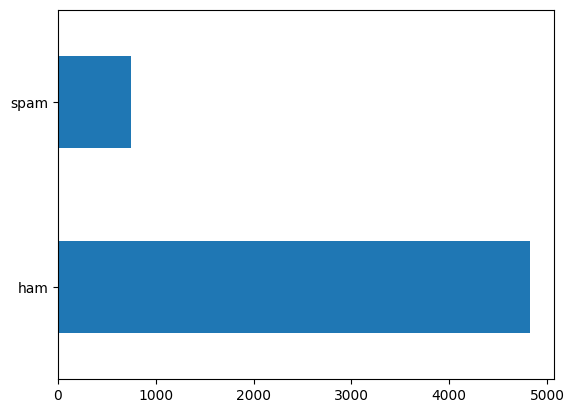

In [30]:
data['label'].value_counts().plot(kind = 'barh')
plt.yticks([0,1] , ['ham','spam'])
plt.show()

In [10]:
data['len'] = data['sms'].apply(lambda x: len(x.split()))
data.head(5)

,sms,label,len
0,"Go until jurong point, crazy.. Available only ...",0,20
1,Ok lar... Joking wif u oni...\n,0,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,28
3,U dun say so early hor... U c already then say...,0,11
4,"Nah I don't think he goes to usf, he lives aro...",0,13


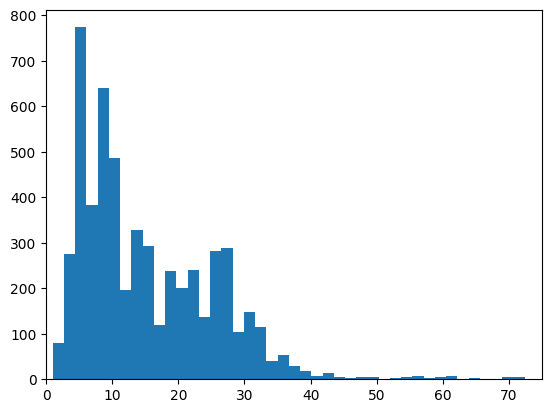

In [11]:
plt.hist(data['len'],bins = 100)
plt.xlim(0,75)
plt.show()

#### 3.2 Clean Data

Punctuation Removal

In [41]:
import string

def remove_punctuation(text):
  punctuationfree = "".join([i for i in text if i not in string.punctuation])
  return punctuationfree
Example = "Hi! Nice to meet you !!"
print("Example: ",Example)
print(remove_punctuation(Example))

Example:  Hi! Nice to meet you !!
Hi Nice to meet you 


In [42]:
data['sms'] = data['sms'].apply(lambda x: remove_punctuation(x))

Lowering the Text

In [43]:
data['sms'] = data['sms'].apply(lambda x: x.lower())
data['sms']

0       go until jurong point crazy available only in ...
1                               ok lar joking wif u oni\n
2       free entry in 2 a wkly comp to win fa cup fina...
3           u dun say so early hor u c already then say\n
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5569    this is the 2nd time we have tried 2 contact u...
5570                will ü b going to esplanade fr home\n
5571    pity  was in mood for that soany other suggest...
5572    the guy did some bitching but i acted like id ...
5573                          rofl its true to its name\n
Name: sms, Length: 5574, dtype: object

Removal Stopword

In [44]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
stopword[0:10]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [55]:
def remove_stopword(text):
  token = text.split()
  output = " ".join([i for i in token if i not in stopword])
  return output


In [56]:
print(data['sms'][0])
remove_stopword(data['sms'][0])

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat



'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [57]:
data['sms'] = data['sms'].apply(lambda x: remove_stopword(x))
data['sms'][0]

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [58]:
data['sms']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry 2 wkly comp win fa cup final tkts 2...
3                     u dun say early hor u c already say
4             nah dont think goes usf lives around though
                              ...                        
5569    2nd time tried 2 contact u u £750 pound prize ...
5570                          ü b going esplanade fr home
5571                          pity mood soany suggestions
5572    guy bitching acted like id interested buying s...
5573                                       rofl true name
Name: sms, Length: 5574, dtype: object

Stemming

In [59]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming(text):
  token = text.split()
  stem_text = " ".join([porter_stemmer.stem(word) for word in token])
  return stem_text


In [60]:
print(data['sms'][0])
stemming(stemming(data['sms'][0]))


go jurong point crazy available bugis n great world la e buffet cine got amore wat


'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

Lemmatization

In [64]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemma(text):
  token = text.split()
  output = " ".join([lemmatizer.lemmatize(x) for x in token])
  return output

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [67]:
print(data['sms'][2])
lemma(data['sms'][2])

free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s


'free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s'

In [68]:
data

,sms,label
0,go jurong point crazy available bugis n great ...,0
1,ok lar joking wif u oni,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1
3,u dun say early hor u c already say,0
4,nah dont think goes usf lives around though,0
...,...,...
5569,2nd time tried 2 contact u u £750 pound prize ...,1
5570,ü b going esplanade fr home,0
5571,pity mood soany suggestions,0
5572,guy bitching acted like id interested buying s...,0


In [69]:
data['len'] = data['sms'].apply(lambda x: len(x.split()))
data

,sms,label,len
0,go jurong point crazy available bugis n great ...,0,16
1,ok lar joking wif u oni,0,6
2,free entry 2 wkly comp win fa cup final tkts 2...,1,23
3,u dun say early hor u c already say,0,9
4,nah dont think goes usf lives around though,0,8
...,...,...,...
5569,2nd time tried 2 contact u u £750 pound prize ...,1,20
5570,ü b going esplanade fr home,0,6
5571,pity mood soany suggestions,0,4
5572,guy bitching acted like id interested buying s...,0,14


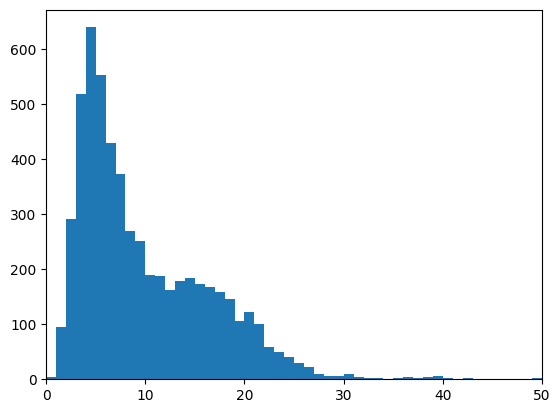

In [74]:
plt.hist(data['len'],bins = 80)
plt.xlim(0,50)
plt.show()

### 3.2 Tokenization & Input formatting
#### BERRT Tokenizer

In [77]:
from transformers import BertTokenizer


In [78]:
print("Loadding Tokenizer .....")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)
print("DONE")

Loadding Tokenizer .....


DONE


Ở đây do data có độ dài khác nhau ở các câu nên chúng ta có thể lựa chọn MAX_LEN .. với những câu dài hơn thì nó sẽ cắt bớt và nhưng câu ngắn hơn thì sẽ được thêm token [PAD] ở cuối. Đi kèm với các token ta có thêm MASK - là một list đi kèm với list input và ở token bình thường thì nó = 1 và ở token PAD thì nó = 0

In [88]:
print("Original: ",data['sms'][0])
print("Tokenizer: ",tokenizer(data['sms'][0],add_special_tokens=True,truncation=True,padding=True)['input_ids'])
print("Mask: ",tokenizer(data['sms'][0])['attention_mask'])

Original:  go jurong point crazy available bugis n great world la e buffet cine got amore wat
Tokenizer:  [101, 2175, 18414, 17583, 2391, 4689, 2800, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 25022, 2638, 2288, 26297, 28194, 102]
Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Việc lựa chọn MAX_LEN sẽ ảnh hưởng đến tốc độ tính toán
  
  * MAX_LEN = 128 ~ 5:28 each
  * MAX_LEN = 64 ~ 2:57 each  

In [84]:
MAX_LEN = 64

In [94]:
def token(text):
  encoded_dict = tokenizer.encode_plus(
      text,
      add_special_tokens = True,
      max_length = 64,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
  )
  return encoded_dict['input_ids'],encoded_dict['attention_mask']
# data['input_ids'],data['attention_mask'] = data['sms'].apply(lambda x: token(x))

In [97]:
a,b = token(data['sms'][0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [98]:
a

tensor([[  101,  2175, 18414, 17583,  2391,  4689,  2800, 11829,  2483,  1050,
          2307,  2088,  2474,  1041, 28305, 25022,  2638,  2288, 26297, 28194,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])

In [100]:
b

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 4. Train

### 4.1 Split training & validation & test dataset

In [1]:
from torch.utils.data import TensorDataSet, random_split

ImportError: ignored

#### 4.1 Model

* BertModel
* BertForPreTraining
* BertForMaskedLM
* <b>BertForNextSequencePrediction</b>
* BertForTokenClassification
* BertForQuestionAnswering


In [102]:
from transformers import BertForSequenceClassification

In [103]:
num_label = 2

In [105]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
     num_labels  = 2,
    output_attentions = False, ## Trả về trọng số attention
    output_hidden_states = False ## Trả về all hidden_states
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

#### 4.2 Optimizer & Learning Rate Scheduler

In [112]:
batch_size = 32
learning_rate = 2e-5
epochs = 4
total_step = len(train_dataloader) * epochs

In [111]:
from transformers import AdamW

In [114]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = 1e-8,)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

#### 4.3 Training

In [ ]:
for epoch in range(epochs):
  print("=========================")
  print(f'================Epoch {epoch + 1}/{epochs}===============')
  print("Training ... ")
  t0 = time.time()
  total_train_loss= 0
  model.train()
  for step, batch in enumerate(train_dataloader):
    if step % 40 == 0 and not step ==0:
      t1 = time.time()
      print(f'Batch {step} of {len(train_dataloader)} - time: {t1 - t0}')
      t0 = t1
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)
    model.zero_grad()
    loss . logits = model(input_ids,
                          token_type_ids = None,
                          attention_mask = attention_mask,
                          labels = label)
    total_train_loss += loss.item()
    loss.backward()
    torch.nn.clip_grad_norm(model.parameters(),1.0)
    optimizer.step()
    scheduler.step()
avg_loss = total_train_loss/len(train_dataloader)
training_time = t1 - t0

### 5. Performance on test set

####

### 6. Appendix

#### 6.1 Save and Loading Fine-Tuned Model

#### 6.2 Weight Decay